In [1]:
import os, sys, glob
import time
import timeit
import utils

import math
import numpy as np
from numpy import linalg as la 
import matplotlib
from matplotlib import rc
import matplotlib.pylab as plt

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

import healpy as hp
import pandas as pd
import logging

from sklearn.neighbors import BallTree

from astropy_healpix import HEALPix
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy import units as u

import scipy.stats
from scipy import interpolate
from scipy import stats
from scipy.stats import chisquare
from scipy.stats import chi2
from scipy.interpolate import UnivariateSpline

import warnings
warnings.filterwarnings('ignore')

In [2]:
def to_coordinates(Dec, RA):
    """
    This function is used for combining right ascension and declinantion data 
    into sperical coordinates with the form [latitude, longtitude], [Dec, RA].
    
    Parameters
    ----------
    RA: float []
        an array of right ascension data
    Dec: float []
        an array of declination data
        
    Returns
    -------
    
    data_points:
        an array of data points in spherical coordinates.
    """
        
    data_point = []
    
    for i in range(len(RA)):
        data_point.append([Dec[i], RA[i]])
        
    return data_point



def cdf_vol_knn(vol):
    """
    Computes an interpolating function to evaluate CDF 
    at a given radius.
    
    Parameters
    ----------
    
    vol: float[:,:]
        List of nearest neighbor distances for each kNN. With each row array represent
        all kNN distances for a specific query points, and the column lenghth is the 
        number of nearest neighbor measured for. 
        
        vol.shape[0] should be # of query points
        vol.shape[1] should be # of kNN measured for each query point.
    
    Returns
    -------
    
    cdf: scipy interpolating function for each kNN, .
         where cdf[k] means the one for kNN-CDF
          
    Reference:
    ----------
    Github link: https://github.com/arkabanerjee/icecube_knn/blob/main/knn.ipynb
    Author: Arka Banerjee, 2022.     
         
    """
    
    cdf = []
    n = vol.shape[0]
    l = vol.shape[1]
  
    gof = ((np.arange(0, n) + 1) / (n*1.0)) # evenly spaced values with # = total number of points
    for c in range(l):
        ind = np.argsort(vol[:, c]) # sort the cNN distances for all query points
        s_vol= vol[ind, c] # a sorted array of cNN distances for all query points
        
        # calculating the interplolating function
        cdf.append(interpolate.interp1d(s_vol, gof, kind='linear', 
                                        bounds_error=False))
    return cdf


def cross_correlation(WISE_catalog, Events_catalog, query_points, k, K, bins):
    """
    This compute the cross-correlation between the WISE galaxy sample (WISE_catalog)
    and the synthetic events or real IceCube data (Events_catalog)
    
    Parameters
        ----------
        WISE_catalog : `list`
            WISE galaxy sample in the form of a nested list of [Dec, RA]
            coordinates in radian
        Events_catalog: 'list'
            The events catalog (can be synthetic data or real IceCube data)
            in the form of a nested list of [Dec, RA] coordinates in radian
        query_points: `np.ndarray`
            An nseted array of query points in the form of [Dec, RA] coordinates per entry 
        k: 'int'
            The maximum k that will be computed for the kNN-CDFs   
        K: 'list'
            A list of integers from 1 to k (smaller-case k defined above) 
        bins: 'list'
            Linear bins that will be used for the interpolation for each k
            in the form of a nested list

        Returns
        -------
        cc : `list`
            A list of in total of k ndarrays, and each of them correspond
            to the computed cross-correlation at each k
    
    """
    # ball tree computation with WISE catalog
    ballTree_1 = BallTree(WISE_catalog, metric = "haversine")
    dist_WISE, ind_wise = ballTree_1.query(query_points, k = k) 
    
    # ball tree computation with events catalog
    ballTree_2 = BallTree(Events_catalog, metric = "haversine")
    dist_target, ind_IC = ballTree_2.query(query_points, k = k) 
    
    # creating the joint kNN distances
    # for a specific query point, defined to the larger distance from the two datasets
    dist_correlated = np.maximum(dist_target, dist_WISE) # joint of events (IceCube) and WISE

    # interpolating functions of joint kNN-CDFs for correlated and uncorrelated CSR sample
    # cdf_correlated [0], [1], [2], [3] represents the interpolating function for the first four kNN-CDFs
    cdf_correlated = cdf_vol_knn(dist_correlated)

    # calculatingg the interpolatig functions for kNN-CDFS of the three datasets 
    cdf_1 = cdf_vol_knn(dist_WISE) # individual (not joint) CDF of WISE
    cdf_2 = cdf_vol_knn(dist_target) # individual CDF of IceCube
        
    cc = []
    for i in range(len(K)):
        cc.append(cdf_correlated[K[i]-1](bins[i]) - cdf_1[K[i]-1](bins[i]) * cdf_2[K[i]-1](bins[i]))
        
    return cc


def compute_mean_vector(samples):
    """
    This is a helper function that compute the mean vectors
    from the input samples, which can be 1000 cross-correlations for instance
    
    """
    mean_vector = np.zeros(len(samples[0]))
    
    for i in range(len(samples)):
        mean_vector += samples[i]
        
    mean_vector = mean_vector/len(samples)
    
    return mean_vector

In [3]:
# set-up for synthetic events generation
# read from IceCube public 10yr data: 2008 - 2018
public_data_directory = "./icecube_10year_ps/"

data = [os.path.join(public_data_directory, "events/IC86_II_exp.csv"),
        os.path.join(public_data_directory, "events/IC86_III_exp.csv"),
        os.path.join(public_data_directory, "events/IC86_IV_exp.csv"),
        os.path.join(public_data_directory, "events/IC86_V_exp.csv"),
        os.path.join(public_data_directory, "events/IC86_VI_exp.csv"),
        os.path.join(public_data_directory, "events/IC86_VII_exp.csv")]

In [4]:
# read query points
df_query_points = pd.read_csv('./data/Query.csv', sep='\t', encoding='utf-8')  
query_points = np.array(df_query_points.values.tolist())

# read WISE data
df_wise = pd.read_csv('./data/WISE.csv', sep='\t', encoding='utf-8')  
WISE = df_wise.values.tolist()

# read linear bins from pkl file as pandas df
df_binc = pd.read_pickle("./data/binc.pkl")
binc = df_binc.values.tolist()

              ra       dec     sigma  logE
1       3.012386  0.023963  0.006458  3.01
2       2.750883  0.152821  0.011868  3.57
6       0.014050  0.193330  0.003840  3.45
8       0.757962  0.814859  0.027576  2.89
9       4.185195  0.013509  0.020595  3.04
...          ...       ...       ...   ...
145741  5.862090  0.471012  0.003840  3.01
145742  4.443137  0.224362  0.007330  2.97
145743  1.861114  0.380447  0.013439  2.90
145746  3.343126  0.077056  0.021468  2.94
145749  3.722944  0.082170  0.004363  3.28

[451953 rows x 4 columns]


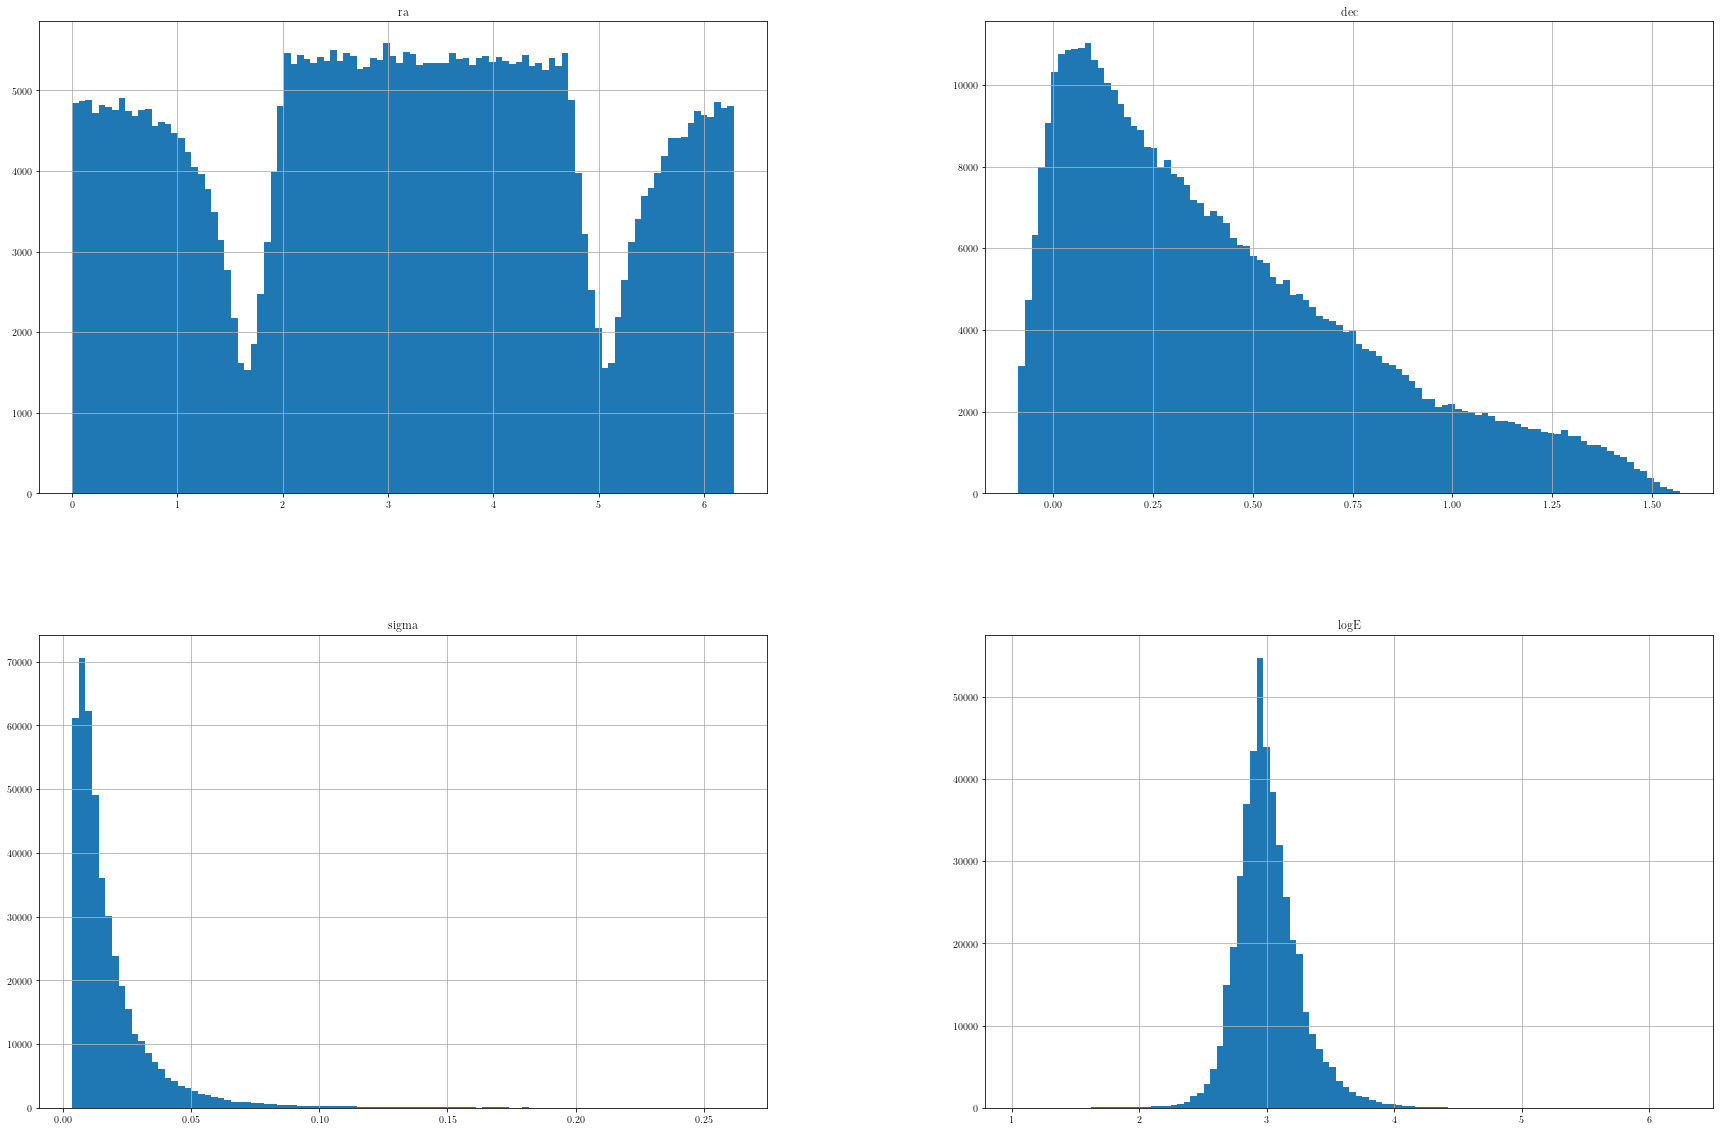

In [5]:
# read and mask IceCube’s public ten-year point-source data
ic10 = utils.read_to_pandas(data)

ic10 = pd.DataFrame({"ra":np.radians(ic10['RA[deg]']), 
                     "dec":np.radians(ic10['Dec[deg]']),
                     "sigma":np.radians(ic10['AngErr[deg]']),
                     "logE":ic10['log10(E/GeV)']})

dec = ic10['dec']
ra = ic10['ra']

# masking
c_icrs = SkyCoord(ra=ra, dec=dec, frame='icrs', unit=(u.radian, u.radian))
index = (np.where(np.abs(c_icrs.galactic.b.degree)>=10))
masked_ic = ic10.iloc[index]

index = (np.where(np.degrees(masked_ic['dec'].values) > -5))
masked_ic = masked_ic.iloc[index[0]]      

# histogram
print (masked_ic)
hist = masked_ic.hist(bins=100, figsize=(30, 20))

# extract and combine RA and Dec coordinates into pairs
RA_longtitude= masked_ic["ra"].to_numpy()
Dec_latitude= masked_ic["dec"].to_numpy()
IceCube_data = to_coordinates(Dec_latitude, RA_longtitude)

In [7]:
# compute the cross-correlations with maximum k of 30
# note that this may take a little bit longer (around 2 - 3 minutes)
cc_ic = cross_correlation(WISE, IceCube_data, query_points, 30, list(range(1, 31)), binc)

In [8]:
# read 2 already-computed cross-correlations 
correlated_cc = [[] for i in range(2)]

# cross-correlations between WISE and synthetic astmospheric-only events
correlated_cc[0] = pd.read_pickle("./data/uncorrelated_cc.pkl").values.tolist() 

# cross-correlations between WISE and synthetic atm. + astro. events with f_astro ~ 0.186
correlated_cc[1] = pd.read_pickle("./data/correlated_cc_1-864.pkl").values.tolist()

range_k = list(range(1, 31))
plot_k = [1,5,10,20]

# some data manipulation below
# data processing into 30 by 1000
holder1 = [[] for i in range(len(correlated_cc))] # total length = number of f_astro
for i in range(len(correlated_cc)):
    # len = 30, holding 1000 samples at each k for a specific f_astrto
    holder3 = [[] for i in range(len(range_k))] 
    for j in range(len(range_k)): # through each k
        # len = 1000, synthetic samples for a specific k
        holder2 = [[] for i in range(len(correlated_cc[0][0]))]
        for k in range(len(correlated_cc[0][0])): # through each sample
            # fix a specific f_astro, for each 1 out of the 1000, attach the jth 
            holder2[k] = correlated_cc[i][0][k][j] # 
        holder3[j] = holder2
    holder1[i] = holder3
    
correlated_cc = holder1

# calculate the mean vectors for the cross-correlations at f_astro = 0 and f_astro ~ 0.186
mean_vectors = [[] for i in range(len(correlated_cc))]

for i in range(len(correlated_cc)):
    holder = [[] for i in range(len(range_k))] # for each f_astro, create a len = 30 list
    for j in range(len(range_k)):
        holder[j] = compute_mean_vector(correlated_cc[i][j])
        
    mean_vectors[i] = holder

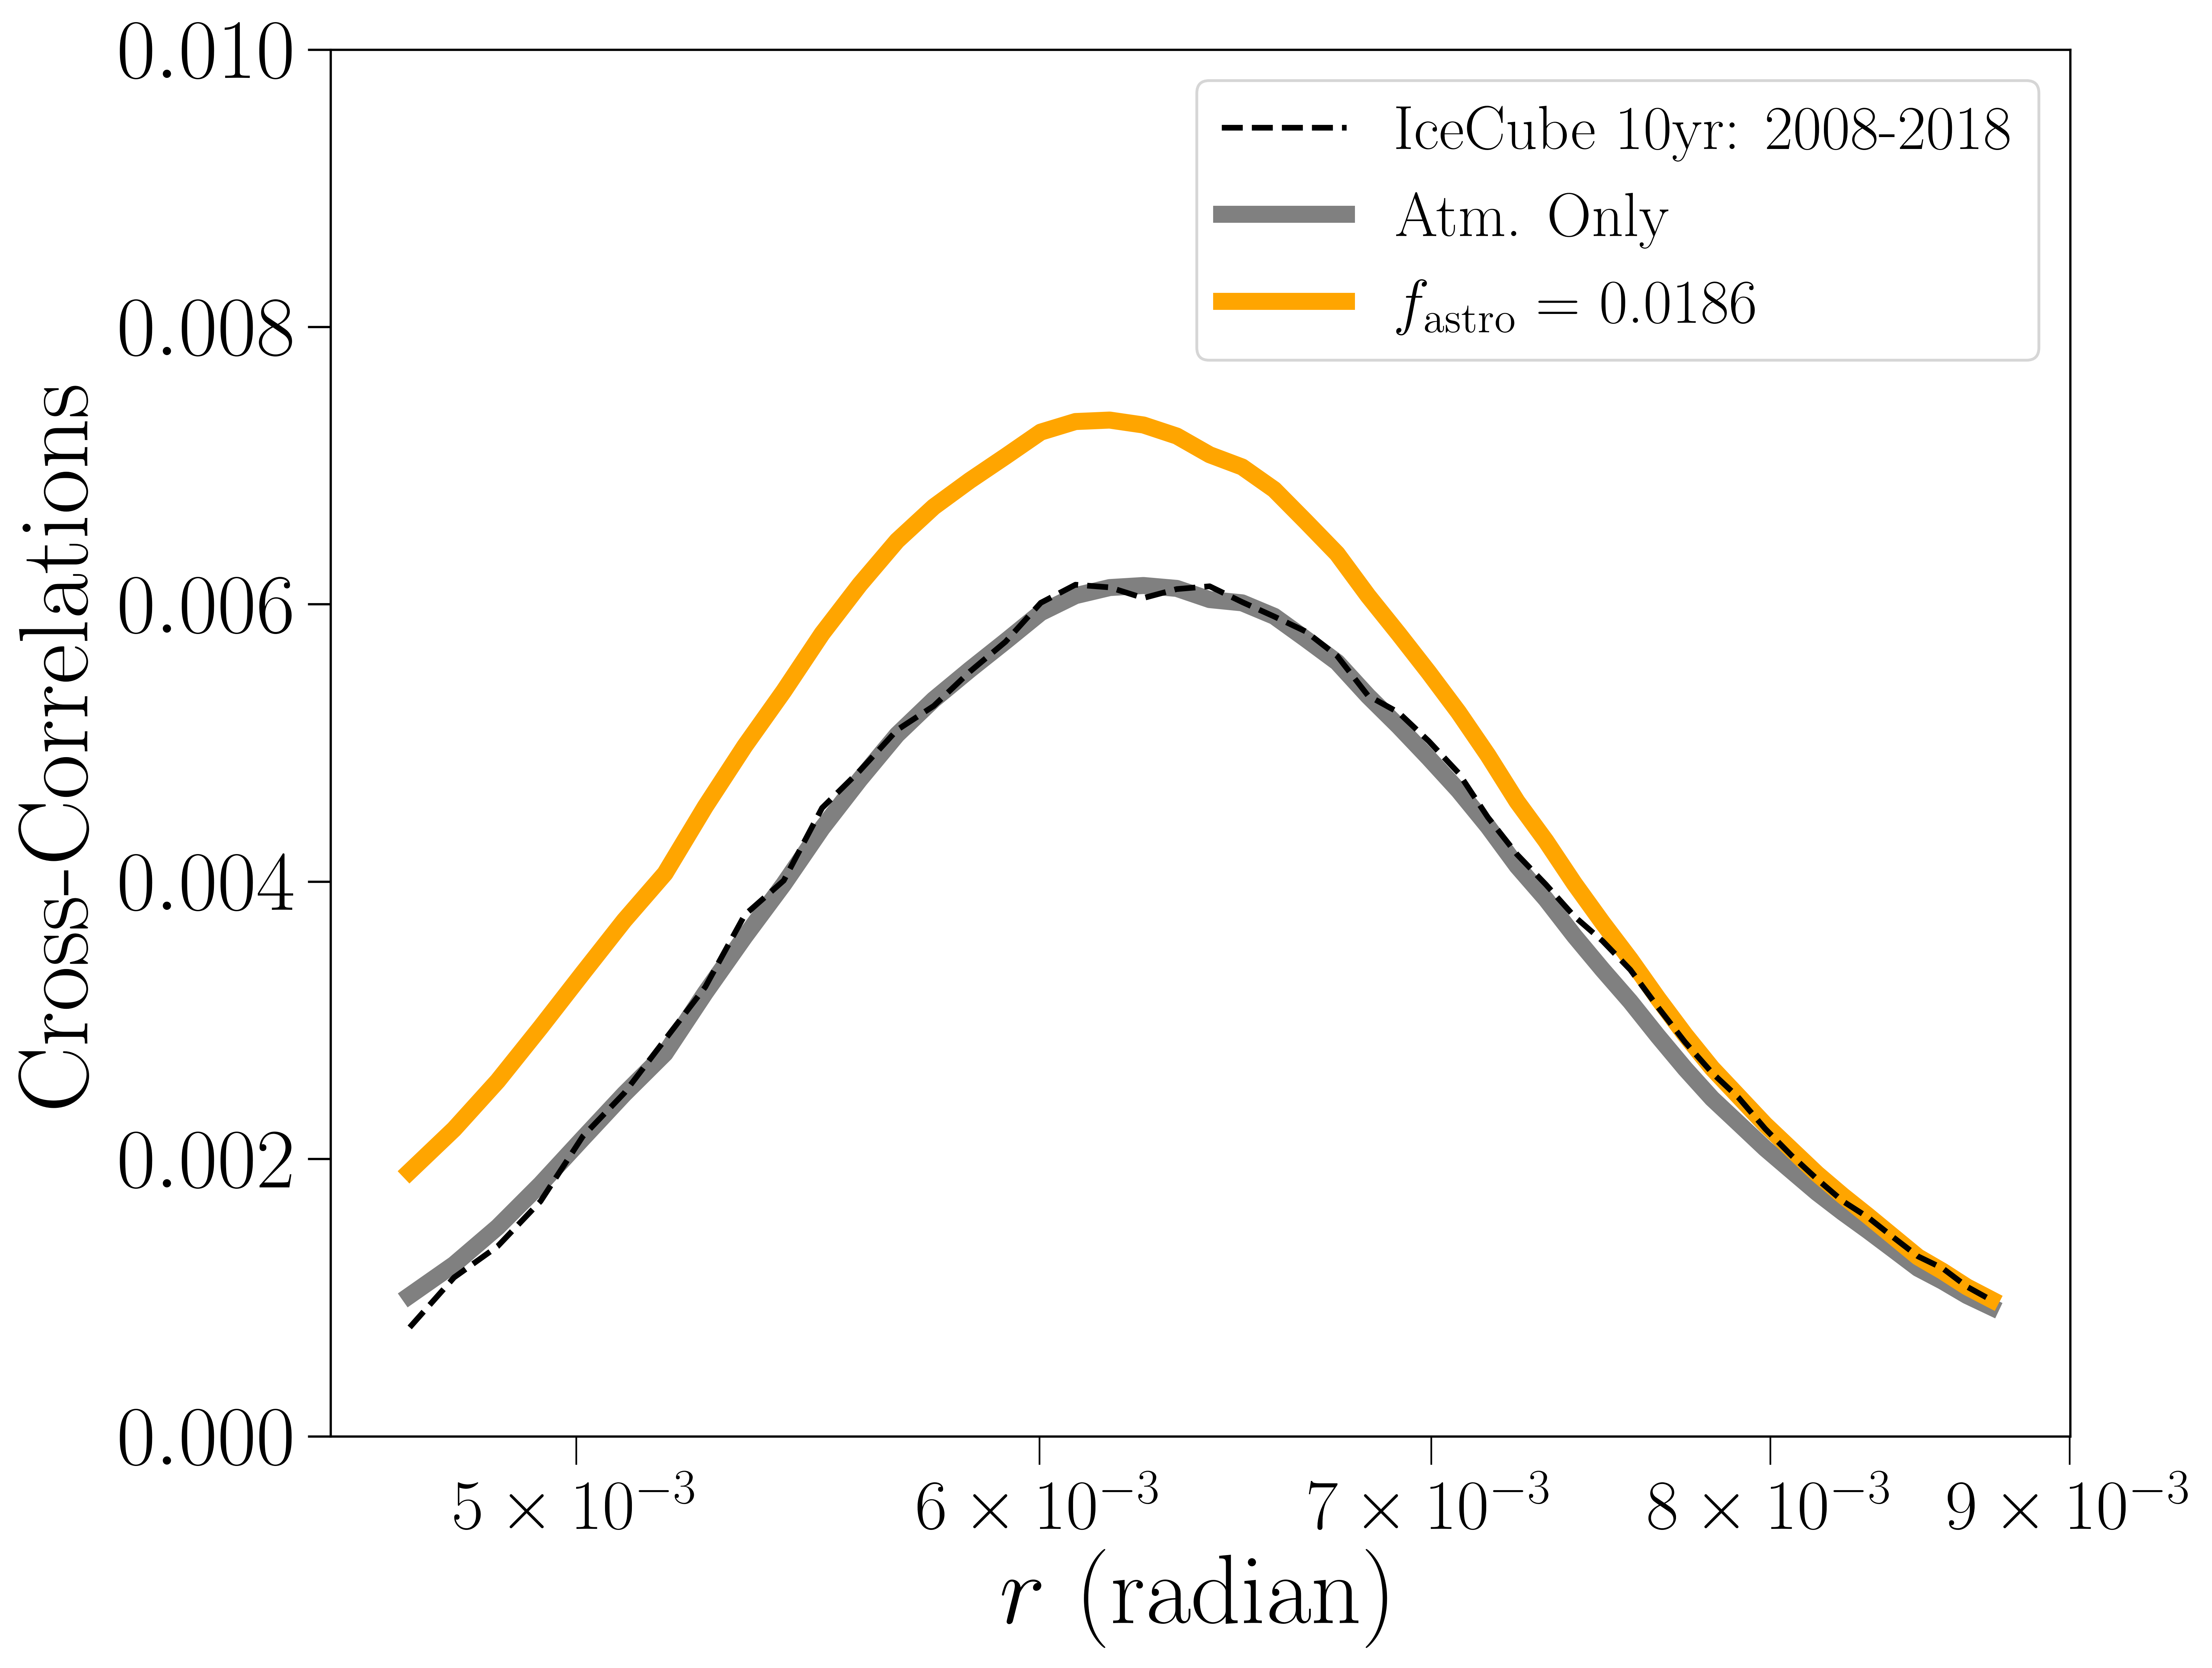

In [10]:
# reproducing the Figure 5 in tha paper
k = 7

fig = plt.figure(figsize=(11, 9), dpi = 600)
plt.xlabel('$r$ (radian)', fontsize = 35)
plt.ylabel('Cross-Correlations', fontsize = 35)
plt.xscale("log")
plt.ylim(0,0.01)

matplotlib.rc('xtick', labelsize=25)
matplotlib.rc('xtick.major', size=25)  # Length of major ticks
matplotlib.rc('xtick.minor', size=10)   # Length of minor ticks

plt.yticks(fontsize = 30)
plt.tick_params(axis='y', which='major', length=8)

plt.plot(binc[k], cc_ic[k], linewidth=2, color = "black", 
         zorder=2, label= "IceCube 10yr: 2008-2018", linestyle="dashed")

plt.plot(binc[k], mean_vectors[0][k], linewidth=6, color = "grey", 
         zorder=1, label= 'Atm. Only')

plt.plot(binc[k], mean_vectors[1][k], linewidth=6, color = "orange", 
         zorder=1, label= '$f_{\mathrm{astro}}$ = 0.0186')


plt.legend(prop={'size': 22})
plt.show()